In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from sklearn.calibration import calibration_curve

import pickle
from sklearn.metrics import accuracy_score, f1_score
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibrationDisplay

In [7]:
# Suppress the SettingWithCopyWarning
pd.set_option('mode.chained_assignment', None)
pd.set_option('future.no_silent_downcasting', True)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
# Load data from the CSV file
df_snapshot = pd.read_csv('../feature-mart/customer_behavior_ecom_snapshot_FRM.csv')

In [9]:
# Get the test data
df_snapshot_truncate = df_snapshot[(df_snapshot.time_snapshot<='2011-12-1')] 
df_snapshot_truncate['is_churn_future_1_month'] = df_snapshot_truncate.num_successful_orders_future_1_month==0

time_split = '2011-11-01'
df_test = df_snapshot_truncate[df_snapshot_truncate.time_snapshot>=time_split]

In [10]:
df_test

,customer_id,total_successful_amount_past_5_month,num_successful_orders_past_5_month,total_successful_amount_past_4_month,num_successful_orders_past_4_month,total_successful_amount_past_3_month,num_successful_orders_past_3_month,total_successful_amount_past_2_month,num_successful_orders_past_2_month,total_successful_amount_past_1_month,...,total_successful_amount_future_2_month,num_successful_orders_future_2_month,time_snapshot,recency,frequency,monetary,RecencyScore,FrequencyScore,MonetaryScore,is_churn_future_1_month
24723,12347.0,382.52,18.0,0.00,0.0,584.91,22.0,0.00,0.0,1294.32,...,224.82,11.0,2011-11-01,0,171,4085.18,5,5,5,True
24724,12359.0,1109.32,47.0,0.00,0.0,0.00,0.0,0.00,0.0,2876.85,...,-91.25,4.0,2011-11-01,18,250,6336.78,4,5,5,True
24725,12360.0,0.00,0.0,0.00,0.0,534.70,30.0,0.00,0.0,1043.78,...,0.00,0.0,2011-11-01,13,129,2662.06,5,5,5,True
24726,12362.0,0.00,0.0,303.76,19.0,451.35,33.0,829.99,40.0,1641.91,...,529.04,30.0,2011-11-01,3,225,4196.45,5,5,5,False
24727,12364.0,NaN,NaN,NaN,NaN,623.92,34.0,79.80,2.0,299.06,...,310.32,27.0,2011-11-01,1,58,1002.78,5,4,4,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33059,15360.0,NaN,NaN,NaN,NaN,NaN,NaN,427.93,13.0,0.00,...,NaN,NaN,2011-12-01,30,13,427.93,4,1,2,True
33060,13103.0,NaN,NaN,NaN,NaN,NaN,NaN,243.94,8.0,0.00,...,NaN,NaN,2011-12-01,30,8,243.94,4,1,2,True
33061,15667.0,NaN,NaN,NaN,NaN,NaN,NaN,301.32,13.0,0.00,...,NaN,NaN,2011-12-01,30,13,301.32,4,1,2,True
33062,16127.0,NaN,NaN,NaN,NaN,NaN,NaN,656.25,40.0,0.00,...,NaN,NaN,2011-12-01,30,40,656.25,3,3,3,True


In [11]:
# Define the features and target 
features = ['customer_id', 
            'total_successful_amount_past_5_month', 'num_successful_orders_past_5_month',
            'total_successful_amount_past_4_month', 'num_successful_orders_past_4_month',
            'total_successful_amount_past_3_month', 'num_successful_orders_past_3_month', 
            'total_successful_amount_past_2_month', 'num_successful_orders_past_2_month',
            'total_successful_amount_past_1_month', 'num_successful_orders_past_1_month',
            'recency', 'frequency', 'monetary', 'FrequencyScore', 'MonetaryScore', 'RecencyScore']
target = 'is_churn_future_1_month'

In [12]:
# Load model from pickel file
filename = '../models/churn_model_catboost.pkl'
with open(filename, 'rb') as f:
    churn_model = pickle.load(f)

In [13]:
churn_model.predict_proba(df_test[features])[:,1]

array([0.49663789, 0.57451431, 0.52775588, ..., 0.69818437, 0.67877301,
       0.70801436])

Model test Accuracy: 0.787
Model F1 Score: 0.870


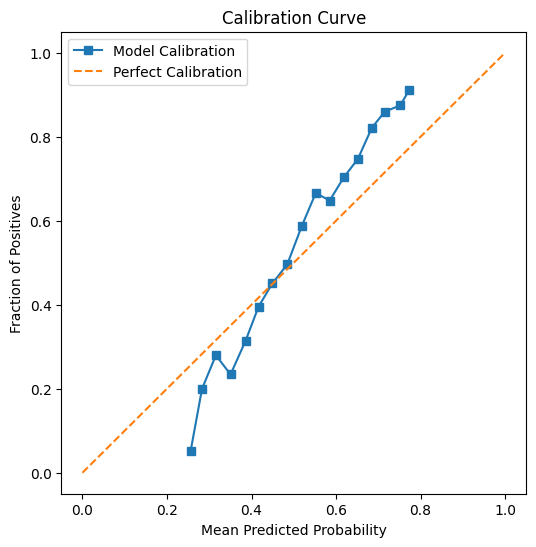

In [14]:
y_test = df_test[target]
y_pred = churn_model.predict_proba(df_test)[:,1]
y_pred = y_pred>=0.5
print(f"Model test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Model F1 Score: {f1_score(y_test, y_pred):.3f}")

# print("Accuracy on training set: {:.3f}".format(model.score(X_train, y_train)))
# print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))
# Make predictions
y_pred = churn_model.predict_proba(df_test)[:,1]

# Compute calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred, n_bins=30)

# Plot calibration curve
plt.figure(figsize=(6, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Model Calibration")
plt.plot([0, 1], [0, 1], "--", label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.legend()
plt.show()

(array([ 129.,  145.,  164.,  258.,  334.,  569.,  730., 1352., 1763.,
        2897.]),
 array([0.2473689 , 0.30028478, 0.35320066, 0.40611655, 0.45903243,
        0.51194831, 0.56486419, 0.61778007, 0.67069595, 0.72361183,
        0.77652771]),
 <BarContainer object of 10 artists>)

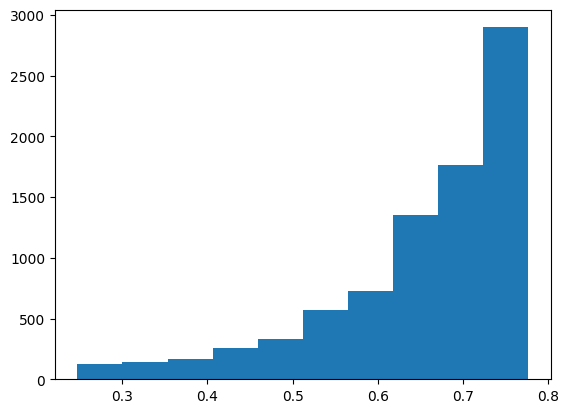

In [15]:
plt.hist(y_pred)

In [16]:
# Recall all models 
with open("../models/churn_model_logistics.pkl", 'rb') as f:
    churn_model_logistics = pickle.load(f)

with open("../models/churn_model_randomforest.pkl", 'rb') as f:
    churn_model_randomforest = pickle.load(f)

with open("../models/churn_model_gradientboosting.pkl", 'rb') as f:
    churn_model_gradientboosting = pickle.load(f)

with open("../models/churn_model_catboost.pkl", 'rb') as f:
    churn_model_catboost = pickle.load(f)

In [17]:
lst_model =[
    (churn_model_logistics, "Logistic Regression"),
    (churn_model_randomforest, "Random Forest"),
    (churn_model_gradientboosting, "Gradient Boosting"),
    (churn_model_catboost, "CatBoost")
]

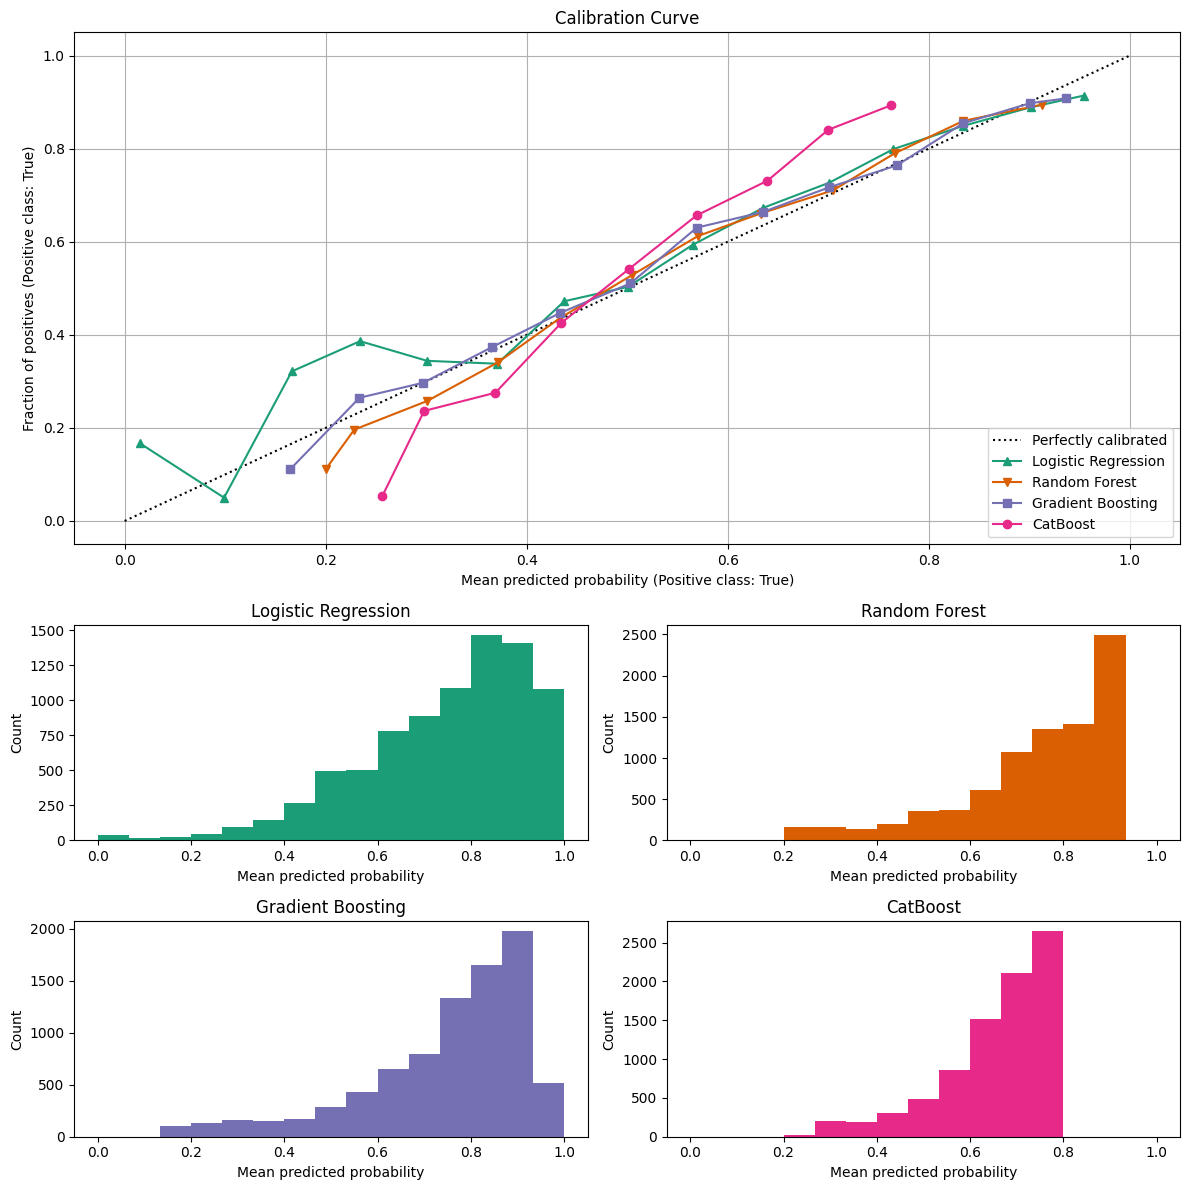

In [25]:
# Plot the calibration curve with the histogram of the predicted probabilities
fig = plt.figure(figsize=(12,12))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

# Calibration curve
ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o"]
for i, (model, name) in enumerate(lst_model):
    display = CalibrationDisplay.from_estimator(model, 
                                df_test,
                                y_test, 
                                ax=ax_calibration_curve, 
                                name=name,
                                n_bins=15, 
                                marker=markers[i], 
                                color=colors(i))
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration Curve")

# Add histogram of the predicted probabilities
grid_positions = [(2,0), (2,1), (3,0), (3,1)]
for i, (_, name) in enumerate(lst_model):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])
    ax.hist(calibration_displays[name].y_prob, 
            bins=15, 
            color=colors(i),           
            range=(0, 1))
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()